In [42]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, to_date, regexp_replace, expr

# Inicializar la sesión de Spark
spark = SparkSession.builder.appName("PySparkApp").getOrCreate()


In [43]:
# Cargar el dataset (reemplaza 'datos_asturias.csv' con la ruta correcta si es necesario)
df = spark.read.csv("datos_asturias.csv", header=True, inferSchema=True)

# Mostrar las primeras filas para revisar los datos
df.show()

+----------+----------+-------------------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+---+-------+-----------+-------+-----------+-------+-----+---------+-----+---------+
|     fecha|indicativo|             nombre|provincia|altitud|tmed|prec|tmin|horatmin|tmax|horatmax|dir|velmedia|racha|horaracha|sol|presMax|horaPresMax|presMin|horaPresMin|hrMedia|hrMax|horaHrMax|hrMin|horaHrMin|
+----------+----------+-------------------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+---+-------+-----------+-------+-----------+-------+-----+---------+-----+---------+
|2019-01-01|     1212E|ASTURIAS AEROPUERTO| ASTURIAS|    127| 5,7| 0,0| 1,5|   04:58| 9,9|   13:30| 13|     4,7|  8,9|    10:44|2,1| 1020,2|     Varias| 1016,8|         01|     90|   98|   Varias|   80|    22:31|
|2019-01-02|     1212E|ASTURIAS AEROPUERTO| ASTURIAS|    127| 7,9| 0,0| 6,0|   23:49| 9,8|  Varias| 99|     4,2| 12,8|    19:18|0,0| 1021,0|     Var

In [44]:
# Definir las columnas que queremos conservar
columnas_deseadas = ["fecha", "tmed", "tmin", "tmax", "hrMedia"]

# Filtrar el dataset
df_limpio = df.select(columnas_deseadas)

# Mostrar las primeras filas del dataset limpio
df_limpio.show(5)

+----------+----+----+----+-------+
|     fecha|tmed|tmin|tmax|hrMedia|
+----------+----+----+----+-------+
|2019-01-01| 5,7| 1,5| 9,9|     90|
|2019-01-02| 7,9| 6,0| 9,8|     76|
|2019-01-03| 6,1| 1,7|10,5|     77|
|2019-01-04| 4,9|-1,4|11,2|     75|
|2019-01-05| 6,1| 0,0|12,2|     74|
+----------+----+----+----+-------+
only showing top 5 rows



In [45]:
# Guardar el nuevo dataset en un archivo CSV limpio
df_limpio.write.csv("datos_asturias_limpio.csv", header=True, mode="overwrite")

print("Archivo limpio guardado como 'datos_asturias_limpio.csv'")


Archivo limpio guardado como 'datos_asturias_limpio.csv'


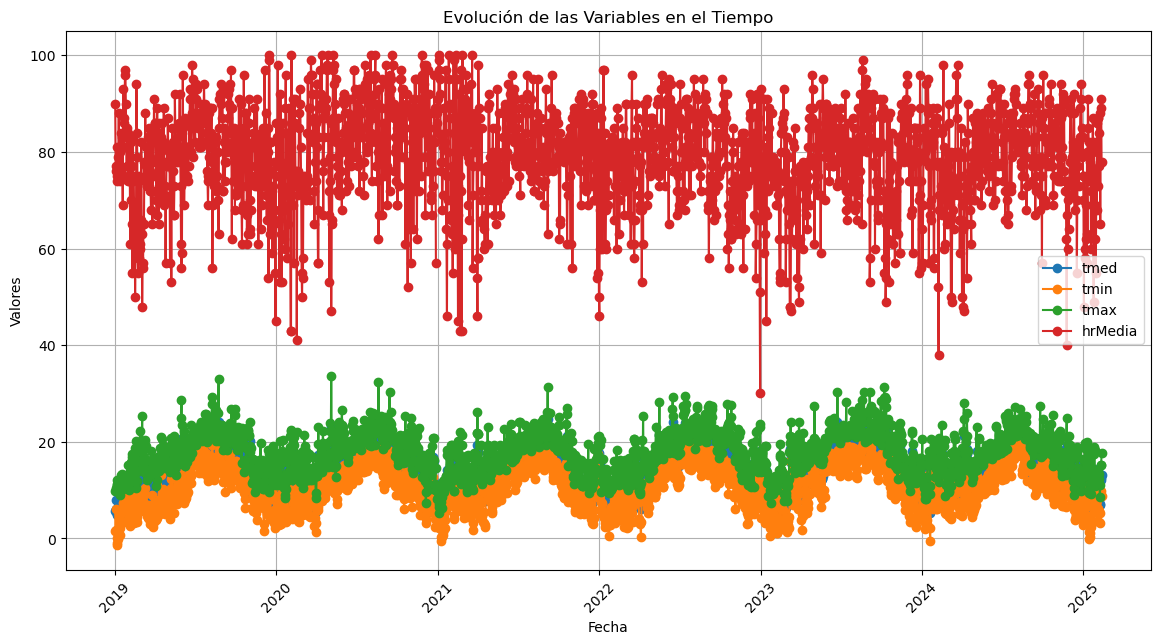

In [46]:
# Cargar el dataset en un DataFrame de Spark
df = spark.read.csv("datos_asturias_limpio.csv", header=True, inferSchema=True)

# Convertir 'fecha' a tipo datetime
df = df.withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd"))

# Eliminar filas donde 'fecha' sea NaN
df = df.filter(col("fecha").isNotNull())

# Reemplazar comas por puntos en las columnas numéricas y usar try_cast para convertir
for column in df.columns:
    if column != "fecha":  # Evitar convertir la columna 'fecha'
        # Reemplazar comas por puntos, luego intentar convertir a tipo double
        df = df.withColumn(column, 
                           expr(f"try_cast(regexp_replace({column}, ',', '.') as double)"))

# Convertir el DataFrame de Spark a Pandas para graficar
pandas_df = df.toPandas()

# Graficar todas las variables numéricas
plt.figure(figsize=(14, 7))

for col in pandas_df.columns:
    if col != "fecha":  # No graficar la fecha directamente
        plt.plot(pandas_df["fecha"], pandas_df[col], label=col, marker="o", linestyle="-")

plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title("Evolución de las Variables en el Tiempo")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Mostrar la gráfica
plt.show()


+----------+----+
|     fecha|tmed|
+----------+----+
|2019-01-01| 5,7|
|2019-01-02| 7,9|
|2019-01-03| 6,1|
|2019-01-04| 4,9|
|2019-01-05| 6,1|
+----------+----+
only showing top 5 rows

No hay valores NaN en 'tmed'.
Rango de fechas: 2019-01-01 a 2025-02-11


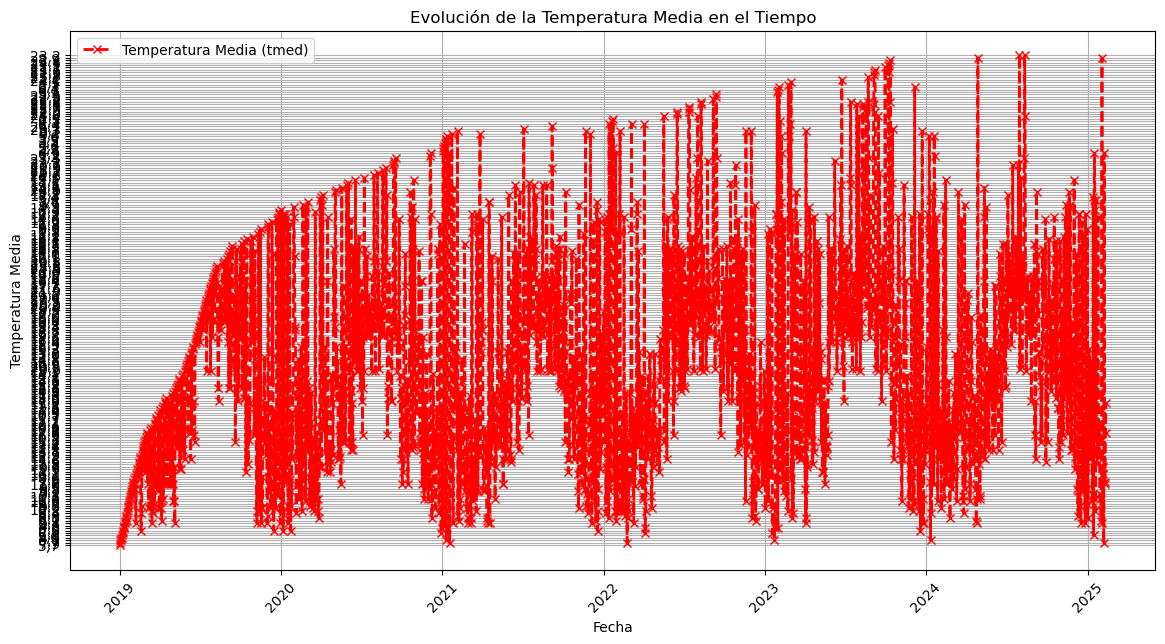

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, min, max
import matplotlib.pyplot as plt

# Crear la sesión de Spark
spark = SparkSession.builder.appName("PySparkApp").getOrCreate()

# Cargar el dataset en un DataFrame de Spark
df = spark.read.csv("datos_asturias_limpio.csv", header=True, inferSchema=True)

# Convertir 'fecha' a tipo datetime
df = df.withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd"))

# Eliminar filas donde 'fecha' o 'tmed' sean NaN
df = df.filter(col("fecha").isNotNull() & col("tmed").isNotNull())

# Verificar las primeras filas para asegurarse de que los datos estén correctos
df.select("fecha", "tmed").show(5)  # Muestra las primeras filas de 'fecha' y 'tmed'

# Verificar si hay valores NaN en la columna tmed
tmed_is_null = df.filter(col("tmed").isNull()).count()
if tmed_is_null > 0:
    print("Hay valores NaN en 'tmed'.")
else:
    print("No hay valores NaN en 'tmed'.")

# Verificar el rango de las fechas
fecha_min_max = df.select(min("fecha"), max("fecha")).collect()

# Acceder a los valores min y max
min_fecha = fecha_min_max[0][0]
max_fecha = fecha_min_max[0][1]

print("Rango de fechas:", min_fecha, "a", max_fecha)

# Convertir el DataFrame de Spark a Pandas para graficar
pandas_df = df.toPandas()

# Graficar solo la temperatura media (tmed)
plt.figure(figsize=(14, 7))
plt.plot(pandas_df["fecha"], pandas_df["tmed"], label="Temperatura Media (tmed)", color="red", marker="x", linestyle="--", linewidth=2)

plt.xlabel("Fecha")
plt.ylabel("Temperatura Media")
plt.title("Evolución de la Temperatura Media en el Tiempo")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Mostrar la gráfica
plt.show()


In [52]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, lag, lead
from pyspark.sql.window import Window

# Crear la sesión de Spark
spark = SparkSession.builder.appName("PySparkApp").getOrCreate()

# Cargar el dataset en un DataFrame de Spark
df = spark.read.csv("datos_asturias_limpio.csv", header=True, inferSchema=True)

# Convertir 'fecha' a tipo datetime
df = df.withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd"))

# Reemplazar comas por puntos en la columna 'tmed' (y otras columnas numéricas si es necesario)
df = df.withColumn("tmed", when(col("tmed").contains(","), 
                                regexp_replace(col("tmed"), ",", "."))
                   .otherwise(col("tmed")))

# Convertir la columna 'tmed' a tipo numérico (debe manejar los errores correctamente)
df = df.withColumn("tmed", col("tmed").cast("double"))

# Ordenar los datos por fecha (importante para que los días estén en orden)
df = df.orderBy("fecha")

# Función para rellenar los valores nulos en 'tmed' con la media entre el valor anterior y posterior
window_spec = Window.orderBy("fecha")

# Usar las funciones lag y lead para obtener los valores anterior y posterior
df = df.withColumn("tmed_prev", lag("tmed", 1).over(window_spec)) \
       .withColumn("tmed_next", lead("tmed", 1).over(window_spec))

# Rellenar los valores nulos de 'tmed' con la media entre el valor anterior y posterior
df = df.withColumn("tmed", when(col("tmed").isNull(),
                                (col("tmed_prev") + col("tmed_next")) / 2)
                  .otherwise(col("tmed")))

# Eliminar las columnas auxiliares
df = df.drop("tmed_prev", "tmed_next")

# Mostrar el dataset después de rellenar los nulos
df.show(50)



+----------+----+----+----+-------+
|     fecha|tmed|tmin|tmax|hrMedia|
+----------+----+----+----+-------+
|2019-01-01| 5.7| 1,5| 9,9|     90|
|2019-01-02| 7.9| 6,0| 9,8|     76|
|2019-01-03| 6.1| 1,7|10,5|     77|
|2019-01-04| 4.9|-1,4|11,2|     75|
|2019-01-05| 6.1| 0,0|12,2|     74|
|2019-01-06| 5.0|-1,0|11,0|     81|
|2019-01-07| 4.9|-0,2|10,0|     76|
|2019-01-08| 6.2| 0,9|11,6|     79|
|2019-01-09| 7.6| 5,1|10,2|     88|
|2019-01-10| 6.0| 2,2| 9,9|     77|
|2019-01-11| 4.8| 0,7| 8,9|     74|
|2019-01-12| 6.0| 2,1| 9,8|     80|
|2019-01-13| 9.4| 5,6|13,1|     75|
|2019-01-14| 8.1| 4,1|12,1|     76|
|2019-01-15| 8.0| 3,4|12,6|     84|
|2019-01-16| 8.3| 3,3|13,3|     75|
|2019-01-17| 8.1| 5,6|10,6|     83|
|2019-01-18| 8.4| 5,5|11,4|     69|
|2019-01-19| 8.8| 7,3|10,3|     93|
|2019-01-20|10.2| 8,1|12,2|     81|
|2019-01-21| 9.0| 6,1|11,8|     86|
|2019-01-22| 8.7| 6,9|10,5|     87|
|2019-01-23|10.6| 9,7|11,4|     96|
|2019-01-24|11.0|10,2|11,7|     97|
|2019-01-25|10.3| 8,2|12,4| 

In [57]:
# Guardar el dataset limpio en un archivo CSV
df.write.option("header", "true").csv("datos_asturias_limpio3.csv")

# Confirmar que el archivo ha sido guardado
print("El archivo limpio ha sido guardado como 'datos_asturias_limpio3.csv'")

El archivo limpio ha sido guardado como 'datos_asturias_limpio3.csv'


In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, lag, lead, regexp_replace
from pyspark.sql.window import Window

# Crear la sesión de Spark
spark = SparkSession.builder.appName("PySparkApp").getOrCreate()

# Cargar el dataset en un DataFrame de Spark
df = spark.read.csv("datos_asturias_limpio3.csv", header=True, inferSchema=True)

# Convertir 'fecha' a tipo datetime
df = df.withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd"))

# Reemplazar comas por puntos en la columna 'tmin'
df = df.withColumn("tmin", when(col("tmin").contains(","), 
                                regexp_replace(col("tmin"), ",", "."))
                   .otherwise(col("tmin")))

# Convertir la columna 'tmin' a tipo numérico (debe manejar los errores correctamente)
df = df.withColumn("tmin", col("tmin").cast("double"))

# Ordenar los datos por fecha (importante para que los días estén en orden)
df = df.orderBy("fecha")

# Función para rellenar los valores nulos en 'tmin' con la media entre el valor anterior y posterior
window_spec = Window.orderBy("fecha")

# Usar las funciones lag y lead para obtener los valores anterior y posterior
df = df.withColumn("tmin_prev", lag("tmin", 1).over(window_spec)) \
       .withColumn("tmin_next", lead("tmin", 1).over(window_spec))

# Rellenar los valores nulos de 'tmin' con la media entre el valor anterior y posterior
df = df.withColumn("tmin", when(col("tmin").isNull(),
                                (col("tmin_prev") + col("tmin_next")) / 2)
                  .otherwise(col("tmin")))

# Eliminar las columnas auxiliares
df = df.drop("tmin_prev", "tmin_next")

# Mostrar las primeras filas del DataFrame después de realizar los cambios
df.show(37)  # Muestra las primeras 10 filas


+----------+----+----+----+-------+
|     fecha|tmed|tmin|tmax|hrMedia|
+----------+----+----+----+-------+
|2019-01-01| 5.7| 1.5| 9,9|     90|
|2019-01-02| 7.9| 6.0| 9,8|     76|
|2019-01-03| 6.1| 1.7|10,5|     77|
|2019-01-04| 4.9|-1.4|11,2|     75|
|2019-01-05| 6.1| 0.0|12,2|     74|
|2019-01-06| 5.0|-1.0|11,0|     81|
|2019-01-07| 4.9|-0.2|10,0|     76|
|2019-01-08| 6.2| 0.9|11,6|     79|
|2019-01-09| 7.6| 5.1|10,2|     88|
|2019-01-10| 6.0| 2.2| 9,9|     77|
|2019-01-11| 4.8| 0.7| 8,9|     74|
|2019-01-12| 6.0| 2.1| 9,8|     80|
|2019-01-13| 9.4| 5.6|13,1|     75|
|2019-01-14| 8.1| 4.1|12,1|     76|
|2019-01-15| 8.0| 3.4|12,6|     84|
|2019-01-16| 8.3| 3.3|13,3|     75|
|2019-01-17| 8.1| 5.6|10,6|     83|
|2019-01-18| 8.4| 5.5|11,4|     69|
|2019-01-19| 8.8| 7.3|10,3|     93|
|2019-01-20|10.2| 8.1|12,2|     81|
|2019-01-21| 9.0| 6.1|11,8|     86|
|2019-01-22| 8.7| 6.9|10,5|     87|
|2019-01-23|10.6| 9.7|11,4|     96|
|2019-01-24|11.0|10.2|11,7|     97|
|2019-01-25|10.3| 8.2|12,4| 

In [60]:
# Guardar el DataFrame resultante en un archivo CSV
df.write.option("header", "true").csv("datos_asturias_limpio_4.csv")

print("Archivo limpio guardado como 'datos_asturias_limpio_4.csv'")

Archivo limpio guardado como 'datos_asturias_limpio_4.csv'


In [68]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, lag, lead, regexp_replace
from pyspark.sql.window import Window

# Crear la sesión de Spark
spark = SparkSession.builder.appName("PySparkApp").getOrCreate()

# Cargar el dataset en un DataFrame de Spark
df = spark.read.csv("datos_asturias_limpio_4.csv", header=True, inferSchema=True)

# Convertir 'fecha' a tipo datetime
df = df.withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd"))

# Reemplazar comas por puntos en la columna 'tmax'
df = df.withColumn("tmax", when(col("tmax").contains(","), 
                                regexp_replace(col("tmax"), ",", "."))
                   .otherwise(col("tmax")))

# Convertir la columna 'tmax' a tipo numérico (debe manejar los errores correctamente)
df = df.withColumn("tmax", col("tmax").cast("double"))

# Ordenar los datos por fecha (importante para que los días estén en orden)
df = df.orderBy("fecha")

# Función para rellenar los valores nulos en 'tmax' con la media entre el valor anterior y posterior
window_spec = Window.orderBy("fecha")

# Usar las funciones lag y lead para obtener los valores anterior y posterior
df = df.withColumn("tmax_prev", lag("tmax", 1).over(window_spec)) \
       .withColumn("tmax_next", lead("tmax", 1).over(window_spec))

# Rellenar los valores nulos de 'tmax' con la media entre el valor anterior y posterior
df = df.withColumn("tmax", when(col("tmax").isNull(),
                                (col("tmax_prev") + col("tmax_next")) / 2)
                  .otherwise(col("tmax")))

# Eliminar las columnas auxiliares
df = df.drop("tmax_prev", "tmax_next")

# Mostrar las primeras filas del DataFrame después de realizar los cambios
df.show(33)  # Muestra las primeras 10 filas

+----------+----+----+----+-------+
|     fecha|tmed|tmin|tmax|hrMedia|
+----------+----+----+----+-------+
|2019-01-01| 5.7| 1.5| 9.9|     90|
|2019-01-02| 7.9| 6.0| 9.8|     76|
|2019-01-03| 6.1| 1.7|10.5|     77|
|2019-01-04| 4.9|-1.4|11.2|     75|
|2019-01-05| 6.1| 0.0|12.2|     74|
|2019-01-06| 5.0|-1.0|11.0|     81|
|2019-01-07| 4.9|-0.2|10.0|     76|
|2019-01-08| 6.2| 0.9|11.6|     79|
|2019-01-09| 7.6| 5.1|10.2|     88|
|2019-01-10| 6.0| 2.2| 9.9|     77|
|2019-01-11| 4.8| 0.7| 8.9|     74|
|2019-01-12| 6.0| 2.1| 9.8|     80|
|2019-01-13| 9.4| 5.6|13.1|     75|
|2019-01-14| 8.1| 4.1|12.1|     76|
|2019-01-15| 8.0| 3.4|12.6|     84|
|2019-01-16| 8.3| 3.3|13.3|     75|
|2019-01-17| 8.1| 5.6|10.6|     83|
|2019-01-18| 8.4| 5.5|11.4|     69|
|2019-01-19| 8.8| 7.3|10.3|     93|
|2019-01-20|10.2| 8.1|12.2|     81|
|2019-01-21| 9.0| 6.1|11.8|     86|
|2019-01-22| 8.7| 6.9|10.5|     87|
|2019-01-23|10.6| 9.7|11.4|     96|
|2019-01-24|11.0|10.2|11.7|     97|
|2019-01-25|10.3| 8.2|12.4| 

In [70]:
# Guardar el DataFrame resultante en un archivo CSV
df.write.option("header", "true").csv("datos_asturias_limpio_6.csv")

print("Archivo limpio guardado como 'datos_asturias_limpio_6.csv'")

Archivo limpio guardado como 'datos_asturias_limpio_6.csv'


In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, lag, lead, regexp_replace
from pyspark.sql.window import Window

# Crear la sesión de Spark
spark = SparkSession.builder.appName("PySparkApp").getOrCreate()

# Cargar el dataset en un DataFrame de Spark
df = spark.read.csv("datos_asturias_limpio_6.csv", header=True, inferSchema=True)

# Convertir 'fecha' a tipo datetime
df = df.withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd"))

# Reemplazar comas por puntos en la columna 'hrMedia'
df = df.withColumn("hrMedia", when(col("hrMedia").contains(","), 
                                regexp_replace(col("hrMedia"), ",", "."))
                   .otherwise(col("hrMedia")))

# Convertir la columna 'hrMedia' a tipo numérico (debe manejar los errores correctamente)
df = df.withColumn("hrMedia", col("hrMedia").cast("double"))

# Ordenar los datos por fecha (importante para que los días estén en orden)
df = df.orderBy("fecha")

# Función para rellenar los valores nulos en 'hrMedia' con la media entre el valor anterior y posterior
window_spec = Window.orderBy("fecha")

# Usar las funciones lag y lead para obtener los valores anterior y posterior
df = df.withColumn("hrMedia_prev", lag("hrMedia", 1).over(window_spec)) \
       .withColumn("hrMedia_next", lead("hrMedia", 1).over(window_spec))

# Rellenar los valores nulos de 'hrMedia' con la media entre el valor anterior y posterior
df = df.withColumn("hrMedia", when(col("hrMedia").isNull(),
                                (col("hrMedia_prev") + col("hrMedia_next")) / 2)
                  .otherwise(col("hrMedia")))

# Eliminar las columnas auxiliares
df = df.drop("hrMedia_prev", "hrMedia_next")

# Mostrar las primeras filas del DataFrame después de realizar los cambios
df.show(33)  # Muestra las primeras 10 filas


+----------+----+----+----+-------+
|     fecha|tmed|tmin|tmax|hrMedia|
+----------+----+----+----+-------+
|2019-01-01| 5.7| 1.5| 9.9|   90.0|
|2019-01-02| 7.9| 6.0| 9.8|   76.0|
|2019-01-03| 6.1| 1.7|10.5|   77.0|
|2019-01-04| 4.9|-1.4|11.2|   75.0|
|2019-01-05| 6.1| 0.0|12.2|   74.0|
|2019-01-06| 5.0|-1.0|11.0|   81.0|
|2019-01-07| 4.9|-0.2|10.0|   76.0|
|2019-01-08| 6.2| 0.9|11.6|   79.0|
|2019-01-09| 7.6| 5.1|10.2|   88.0|
|2019-01-10| 6.0| 2.2| 9.9|   77.0|
|2019-01-11| 4.8| 0.7| 8.9|   74.0|
|2019-01-12| 6.0| 2.1| 9.8|   80.0|
|2019-01-13| 9.4| 5.6|13.1|   75.0|
|2019-01-14| 8.1| 4.1|12.1|   76.0|
|2019-01-15| 8.0| 3.4|12.6|   84.0|
|2019-01-16| 8.3| 3.3|13.3|   75.0|
|2019-01-17| 8.1| 5.6|10.6|   83.0|
|2019-01-18| 8.4| 5.5|11.4|   69.0|
|2019-01-19| 8.8| 7.3|10.3|   93.0|
|2019-01-20|10.2| 8.1|12.2|   81.0|
|2019-01-21| 9.0| 6.1|11.8|   86.0|
|2019-01-22| 8.7| 6.9|10.5|   87.0|
|2019-01-23|10.6| 9.7|11.4|   96.0|
|2019-01-24|11.0|10.2|11.7|   97.0|
|2019-01-25|10.3| 8.2|12.4| 

In [72]:
# Guardar el DataFrame resultante en un archivo CSV
df.write.option("header", "true").csv("datos_asturias_limpio_7.csv")

print("Archivo limpio guardado como 'datos_asturias_limpio_7.csv'")

Archivo limpio guardado como 'datos_asturias_limpio_7.csv'
